### Imports: setting up our environment

In [1]:
import copy
import json
import logging
import time

import awkward as ak
import cabinetry
import cloudpickle
import correctionlib
import hist
import matplotlib.pyplot as plt
import numpy as np
import pyhf
from coffea import processor
from coffea.analysis_tools import PackedSelection
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
from matplotlib import pyplot as plt

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

NanoAODSchema.warn_missing_crossrefs = False
logging.getLogger("cabinetry").setLevel(logging.INFO)
USE_INFERENCE = True
LOCAL_FILES = True

/Users/iason/Dropbox/work/coffea_dev/coffea/src/coffea/nanoevents/schemas/edm4hep.py:7: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


### Defining our `coffea` Processor

The processor includes a lot of the physics analysis details:
- event filtering and the calculation of observables,
- event weighting,
- calculating systematic uncertainties at the event and object level,
- filling all the information into histograms that get aggregated and ultimately returned to us by `coffea`.

#### Machine Learning Task

During the processing step, machine learning is used to calculate one of the variables used for this analysis. The models used are trained separately in the `jetassignment_training.ipynb` notebook. Jets in the events are assigned to labels corresponding with their parent partons using a boosted decision tree (BDT). More information about the model and training can be found within that notebook.

In [2]:
class TtbarAnalysis(processor.ProcessorABC):
    def __init__(self, use_inference, use_triton):

        # initialize dictionary of hists for signal and control region
        self.hist_dict = {}
        for region in ["4j1b", "4j2b"]:
            self.hist_dict[region] = (
                hist.Hist.new.Reg(utils.config["global"]["NUM_BINS"], 
                                  utils.config["global"]["BIN_LOW"], 
                                  utils.config["global"]["BIN_HIGH"], 
                                  name="observable", 
                                  label="observable [GeV]")
                .StrCat([], name="process", label="Process", growth=True)
                .StrCat([], name="variation", label="Systematic variation", growth=True)
                .Weight()
            )
        
        self.cset = correctionlib.CorrectionSet.from_file("corrections.json")
        self.use_inference = use_inference
        
        # set up attributes only needed if USE_INFERENCE=True
        if self.use_inference:
            
            # initialize dictionary of hists for ML observables
            self.ml_hist_dict = {}
            for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                self.ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]] = (
                    hist.Hist.new.Reg(utils.config["global"]["NUM_BINS"],
                                      utils.config["ml"]["BIN_LOW"][i],
                                      utils.config["ml"]["BIN_HIGH"][i],
                                      name="observable",
                                      label=utils.config["ml"]["FEATURE_DESCRIPTIONS"][i])
                    .StrCat([], name="process", label="Process", growth=True)
                    .StrCat([], name="variation", label="Systematic variation", growth=True)
                    .Weight()
                )
            
            self.use_triton = use_triton

    def process(self, events):
        if utils.config["benchmarking"]["DISABLE_PROCESSING"]:
            # IO testing with no subsequent processing
            return self.only_do_IO(events)

        # create copies of histogram objects
        hist_dict = copy.deepcopy(self.hist_dict)
        if self.use_inference:
            ml_hist_dict = copy.deepcopy(self.ml_hist_dict)

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        # setup triton gRPC client or xgboost
        if self.use_inference:
            if self.use_triton:
                triton_client = utils.clients.get_triton_client(utils.config["ml"]["TRITON_URL"])
            else:
                if utils.ml.model_even is None:
                    utils.ml.load_models()


        #### systematics
        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = utils.systematics.jet_pt_resolution(events.Jet.pt)

        syst_variations = ["nominal"]
        jet_kinematic_systs = ["pt_scale_up", "pt_res_up"]
        event_systs = [f"btag_var_{i}" for i in range(4)]
        if process == "wjets":
            event_systs.append("scale_var")

        # Only do systematics for nominal samples, e.g. ttbar__nominal
        if variation == "nominal":
            syst_variations.extend(jet_kinematic_systs)
            syst_variations.extend(event_systs)

        # for pt_var in pt_variations:
        for syst_var in syst_variations:
            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # Note: This creates new objects, distinct from those in the 'events' object
            elecs = events.Electron
            muons = events.Muon
            jets = events.Jet
            if syst_var in jet_kinematic_systs:
                # Replace jet.pt with the adjusted values
                jets["pt"] = jets.pt * events[syst_var]

            electron_reqs = (elecs.pt > 30) & (np.abs(elecs.eta) < 2.1) & (elecs.cutBased == 4) & (elecs.sip3d < 4)
            muon_reqs = ((muons.pt > 30) & (np.abs(muons.eta) < 2.1) & (muons.tightId) & (muons.sip3d < 4) &
                         (muons.pfRelIso04_all < 0.15))
            jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

            # Only keep objects that pass our requirements
            elecs = elecs[electron_reqs]
            muons = muons[muon_reqs]
            jets = jets[jet_reqs]

            if self.use_inference:
                even = (events.event%2==0)  # whether events are even/odd

            B_TAG_THRESHOLD = 0.5

            ######### Store boolean masks with PackedSelection ##########
            selections = PackedSelection(dtype='uint64')
            # Basic selection criteria
            selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
            selections.add("atleast_4j", ak.num(jets) >= 4)
            selections.add("exactly_1b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) == 1)
            selections.add("atleast_2b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
            # Complex selection criteria
            selections.add("4j1b", selections.all("exactly_1l", "atleast_4j", "exactly_1b"))
            selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))

            for region in ["4j1b", "4j2b"]:
                region_selection = selections.all(region)
                region_jets = jets[region_selection]
                region_elecs = elecs[region_selection]
                region_muons = muons[region_selection]
                region_weights = np.ones(len(region_jets)) * xsec_weight
                if self.use_inference:
                    region_even = even[region_selection]

                if region == "4j1b":
                    observable = ak.sum(region_jets.pt, axis=-1)

                elif region == "4j2b":

                    # reconstruct hadronic top as bjj system with largest pT
                    trijet = ak.combinations(region_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
                    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)

                    if sum(region_selection)==0:
                        continue

                    if self.use_inference:
                        features, perm_counts = utils.ml.get_features(
                            region_jets,
                            region_elecs,
                            region_muons,
                            max_n_jets=utils.config["ml"]["MAX_N_JETS"],
                        )
                        even_perm = np.repeat(region_even, perm_counts)

                        # calculate ml observable
                        if self.use_triton:
                            results = utils.ml.get_inference_results_triton(
                                features,
                                even_perm,
                                triton_client,
                                utils.config["ml"]["MODEL_NAME"],
                                utils.config["ml"]["MODEL_VERSION_EVEN"],
                                utils.config["ml"]["MODEL_VERSION_ODD"],
                            )

                        else:
                            results = utils.ml.get_inference_results_local(
                                features,
                                even_perm,
                                utils.ml.model_even,
                                utils.ml.model_odd,
                            )
                            
                        results = ak.unflatten(results, perm_counts)
                        features = ak.flatten(ak.unflatten(features, perm_counts)[
                            ak.from_regular(ak.argmax(results,axis=1)[:, np.newaxis])
                        ])
                syst_var_name = f"{syst_var}"
                # Break up the filling into event weight systematics and object variation systematics
                if syst_var in event_systs:
                    for i_dir, direction in enumerate(["up", "down"]):
                        # Should be an event weight systematic with an up/down variation
                        if syst_var.startswith("btag_var"):
                            i_jet = int(syst_var.rsplit("_",1)[-1])   # Kind of fragile
                            wgt_variation = self.cset["event_systematics"].evaluate("btag_var", direction, region_jets.pt[:,i_jet])
                        elif syst_var == "scale_var":
                            # The pt array is only used to make sure the output array has the correct shape
                            wgt_variation = self.cset["event_systematics"].evaluate("scale_var", direction, region_jets.pt[:,0])
                        syst_var_name = f"{syst_var}_{direction}"
                        hist_dict[region].fill(
                            observable=observable, process=process,
                            variation=syst_var_name, weight=region_weights * wgt_variation
                        )
                        if region == "4j2b" and self.use_inference:
                            for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                                ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]].fill(
                                    observable=features[..., i], process=process,
                                    variation=syst_var_name, weight=region_weights * wgt_variation
                                )
                else:
                    # Should either be 'nominal' or an object variation systematic
                    if variation != "nominal":
                        # This is a 2-point systematic, e.g. ttbar__scaledown, ttbar__ME_var, etc.
                        syst_var_name = variation
                    hist_dict[region].fill(
                        observable=observable, process=process,
                        variation=syst_var_name, weight=region_weights
                    )
                    if region == "4j2b" and self.use_inference:
                        for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                            ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]].fill(
                                observable=features[..., i], process=process,
                                variation=syst_var_name, weight=region_weights
                            )


        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist_dict": hist_dict}
        if self.use_inference:
            output["ml_hist_dict"] = ml_hist_dict

        return output

    def postprocess(self, accumulator):
        return accumulator

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [3]:
with open("fileset.json") as f:
    fileset = json.load(f)

if LOCAL_FILES:
    for key, value in fileset.items():
        new_files = [f"root_files/{key}/{file.split('/')[-1]}" for file in value["files"]]
        value["files"] = new_files

fileset

{'ttbar__nominal': {'files': ['root_files/ttbar__nominal/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root',
   'root_files/ttbar__nominal/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0001.root'],
  'metadata': {'process': 'ttbar',
   'variation': 'nominal',
   'nevts': 2631694,
   'xsec': 729.84}},
 'ttbar__scaledown': {'files': ['root_files/ttbar__scaledown/cmsopendata2015_ttbar_19983_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root',
   'root_files/ttbar__scaledown/cmsopendata2015_ttbar_19983_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0001.root'],
  'metadata': {'process': 'ttbar',
   'variation': 'scaledown',
   'nevts': 2555543,
   'xsec': 729.84}},
 'ttbar__scaleup': {'files': ['root_files/ttbar__scaleup/cmsopendata2015_ttbar_19985_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_10000_0000.root',
   'root_files/ttbar__scaleup/cmsopendata2015_ttbar_19985_PU25nsDa

### Events reading function

A function that reads in events with `NanoEventsFactory` in virtual array mode and defines an `access_log` as well to know which branches were accessed

In [4]:
def make_events(file, schemaclass=NanoAODSchema):
    metadata = {"dataset": file.split("/")[1]}
    metadata.update(fileset[file.split("/")[1]]["metadata"])
    access_log = []
    events = NanoEventsFactory.from_root(
        {file: "Events"},
        mode="virtual",
        schemaclass=schemaclass,
        metadata=metadata,
        access_log=access_log,
    ).events()
    return events, access_log

### Test over one file

Open one file and run the `TtbarAnalysis` processor over it.

In [5]:
%%time

events, access_log = make_events(
    "root_files/ttbar__nominal/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root"
)
access_log

CPU times: user 130 ms, sys: 3.05 ms, total: 133 ms
Wall time: 134 ms


[]

In [6]:
%%time

processor_instance = TtbarAnalysis(use_inference=USE_INFERENCE, use_triton=False)
t0 = time.monotonic()
all_histograms = processor_instance.process(events)
exec_time = time.monotonic() - t0
print(f"execution took {exec_time:.2f} seconds")
print("Events/s:", (all_histograms["nevents"][events.metadata["dataset"]] / exec_time))
access_log

execution took 21.12 seconds
Events/s: 63180.29865697642
CPU times: user 42.7 s, sys: 4.01 s, total: 46.7 s
Wall time: 21.1 s


['nJet',
 'nElectron',
 'Electron_pt',
 'Electron_eta',
 'Electron_cutBased',
 'Electron_sip3d',
 'nMuon',
 'Muon_pt',
 'Muon_eta',
 'Muon_tightId',
 'Muon_sip3d',
 'Muon_pfRelIso04_all',
 'Jet_pt',
 'Jet_eta',
 'Jet_jetId',
 'event',
 'Jet_btagCSVV2',
 'Jet_phi',
 'Jet_mass',
 'Electron_phi',
 'Muon_phi',
 'Electron_mass',
 'Muon_mass',
 'Jet_qgl']

### Running over all the files

In [7]:
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here
USE_DASK = False

if USE_DASK:
    from distributed import Client
    
    client = Client(n_workers=10, threads_per_worker=1)
    cloudpickle.register_pickle_by_value(utils) # serialize methods and objects in utils so that they can be accessed within the coffea processor
    executor = processor.DaskExecutor(client=client)
else:
    executor = processor.FuturesExecutor(workers=10)

run = processor.Runner(
    executor=executor,
    schema=NanoAODSchema,
    savemetrics=True,
    metadata_cache={},
    chunksize=utils.config["benchmarking"]["CHUNKSIZE"])

# load local models if not using Triton or FuturesExecutor and models are not yet loaded
if USE_INFERENCE and USE_DASK and utils.ml.model_even is None and utils.ml.model_odd is None:
    utils.ml.load_models()

filemeta = run.preprocess(fileset, treename="Events")  # pre-processing

t0 = time.monotonic()
# processing
all_histograms, metrics = run(
    fileset,
    treename="Events",
    processor_instance=TtbarAnalysis(use_inference=USE_INFERENCE, use_triton=False)
)
exec_time = time.monotonic() - t0

print(f"\nexecution took {exec_time:.2f} seconds")

Output()

/Users/iason/Dropbox/work/coffea_dev/coffea/src/coffea/nanoevents/schemas/edm4hep.py:7: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/Users/iason/Dropbox/work/coffea_dev/coffea/src/coffea/nanoevents/schemas/edm4hep.py:7: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warn

Output()

/Users/iason/Dropbox/work/coffea_dev/coffea/src/coffea/nanoevents/schemas/edm4hep.py:7: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/Users/iason/Dropbox/work/coffea_dev/coffea/src/coffea/nanoevents/schemas/edm4hep.py:7: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warn


execution took 28.77 seconds


In [8]:
metrics

{'bytesread': 3157632583,
 'columns': ['Electron_sip3d',
  'Electron_phi',
  'Electron_mass',
  'Muon_sip3d',
  'Muon_pt',
  'Muon_pfRelIso04_all',
  'Muon_tightId',
  'Jet_eta',
  'event',
  'nElectron',
  'nMuon',
  'Jet_pt',
  'Jet_qgl',
  'Jet_jetId',
  'Jet_btagCSVV2',
  'Jet_phi',
  'Muon_phi',
  'Jet_mass',
  'Electron_eta',
  'nJet',
  'Muon_eta',
  'Electron_cutBased',
  'Electron_pt',
  'Muon_mass'],
 'entries': 19497435,
 'processtime': 222.96359586715698,
 'chunks': 96}

### Inspecting the produced histograms

Let's have a look at the data we obtained.
We built histograms in two phase space regions, for multiple physics processes and systematic variations.

<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\g'
/var/folders/2c/94kt72fs0_q_9nzr2y5jphb00000gn/T/ipykernel_40992/3207510815.py:7: SyntaxWarning: invalid escape sequence '\g'
  plt.title("$\geq$ 4 jets, 1 b-tag")


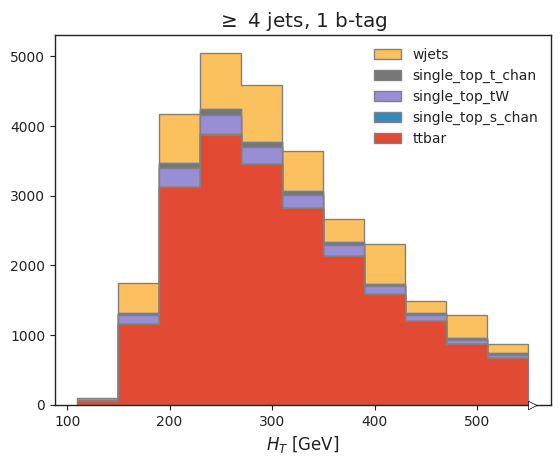

In [9]:
import utils.plotting  # noqa: E402

utils.plotting.set_style()

all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title("$\geq$ 4 jets, 1 b-tag")
plt.xlabel("$H_T$ [GeV]");

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
/var/folders/2c/94kt72fs0_q_9nzr2y5jphb00000gn/T/ipykernel_40992/1212845076.py:3: SyntaxWarning: invalid escape sequence '\g'
  plt.title("$\geq$ 4 jets, $\geq$ 2 b-tags")


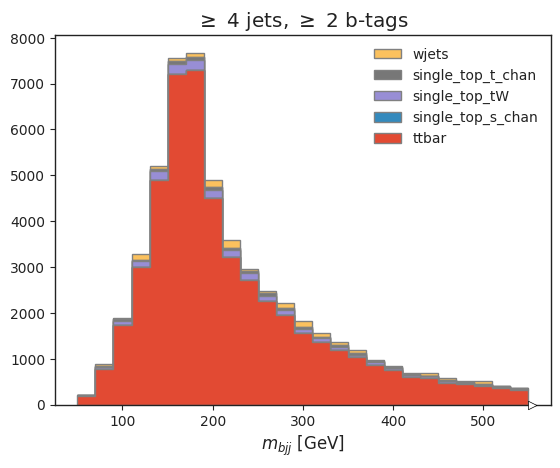

In [10]:
all_histograms["hist_dict"]["4j2b"][:, :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title("$\geq$ 4 jets, $\geq$ 2 b-tags")
plt.xlabel("$m_{bjj}$ [GeV]");

Our top reconstruction approach ($bjj$ system with largest $p_T$) has worked!

Let's also have a look at some systematic variations:
- b-tagging, which we implemented as jet-kinematic dependent event weights,
- jet energy variations, which vary jet kinematics, resulting in acceptance effects and observable changes.

We are making of [UHI](https://uhi.readthedocs.io/) here to re-bin.

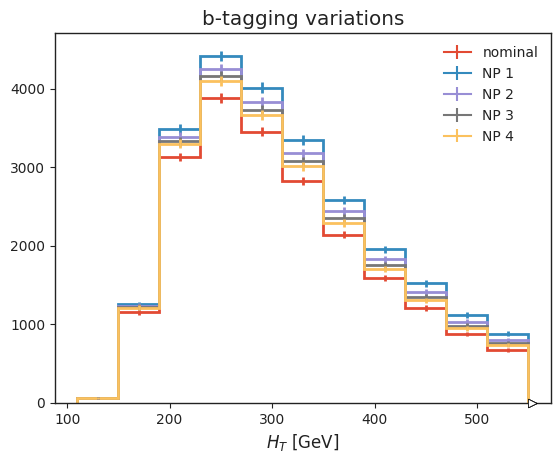

In [11]:
# b-tagging variations
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_0_up"].plot(label="NP 1", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_1_up"].plot(label="NP 2", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_2_up"].plot(label="NP 3", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_3_up"].plot(label="NP 4", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$H_T$ [GeV]")
plt.title("b-tagging variations");

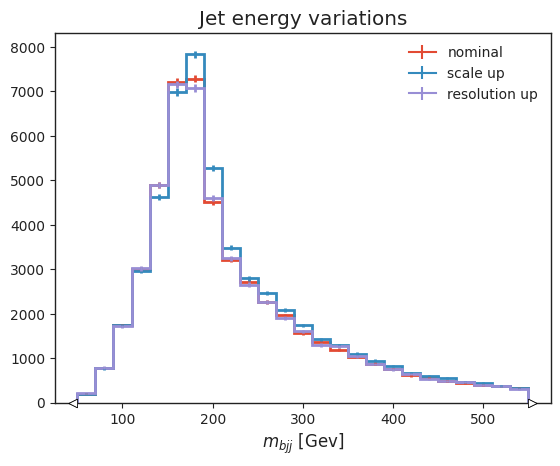

In [12]:
# jet energy scale variations
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "pt_scale_up"].plot(label="scale up", linewidth=2)
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "pt_res_up"].plot(label="resolution up", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$m_{bjj}$ [Gev]")
plt.title("Jet energy variations");

/var/folders/2c/94kt72fs0_q_9nzr2y5jphb00000gn/T/ipykernel_40992/346823961.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


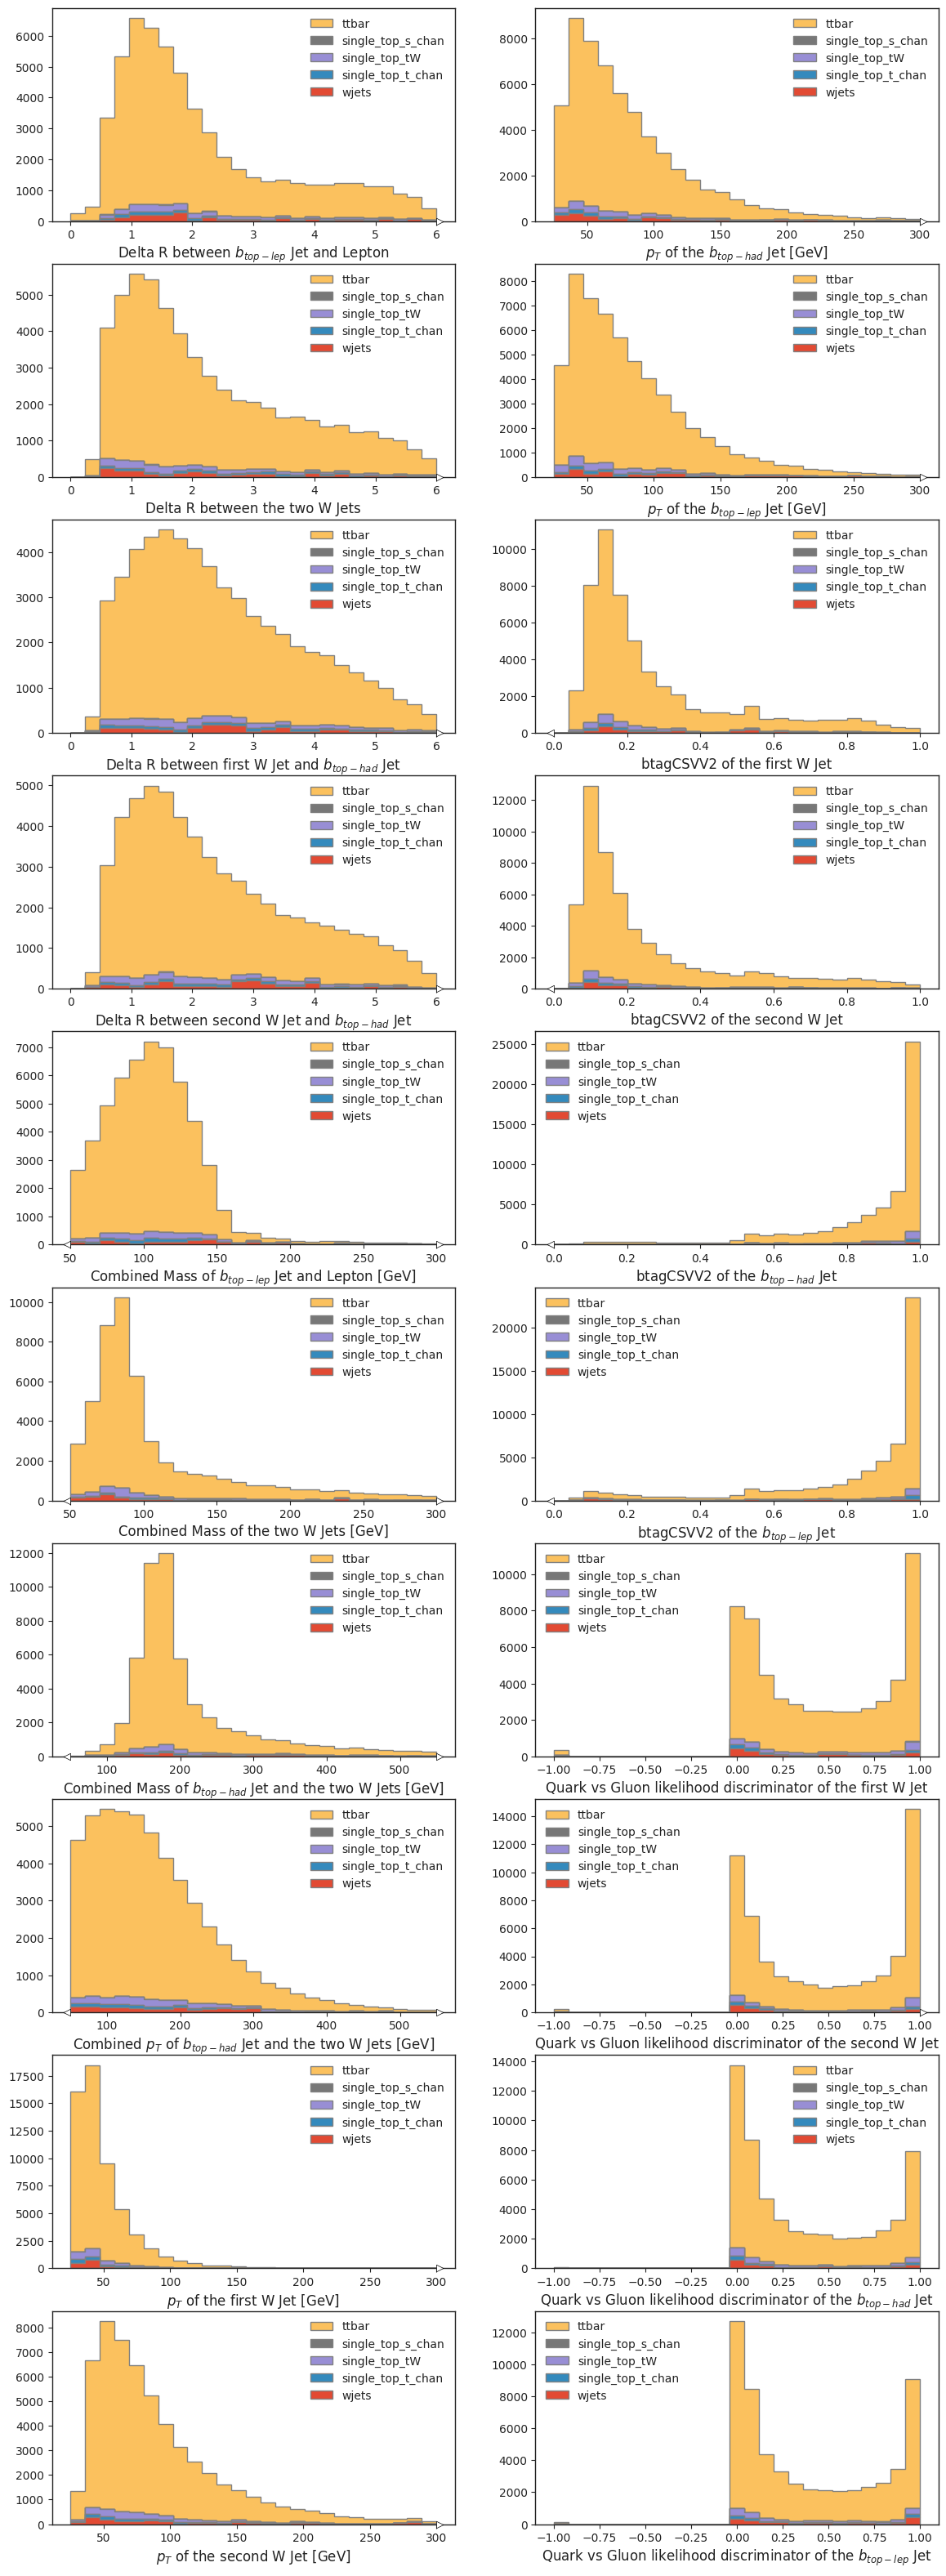

In [13]:
# ML inference variables
if USE_INFERENCE:
    fig, axs = plt.subplots(10,2,figsize=(14,40))
    for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
        if i<10: 
            column=0
            row=i
        else: 
            column=1
            row=i-10
        all_histograms['ml_hist_dict'][utils.config["ml"]["FEATURE_NAMES"][i]][:, :, "nominal"].stack("process").project("observable").plot(
            stack=True, 
            histtype="fill", 
            linewidth=1, 
            edgecolor="grey", 
            ax=axs[row,column]
        )
        axs[row, column].legend(frameon=False)
    fig.show()

### Save histograms to disk

We'll save everything to disk for subsequent usage.
This also builds pseudo-data by combining events from the various simulation setups we have processed.

In [14]:
utils.file_output.save_histograms(all_histograms['hist_dict'], "histograms.root")

if USE_INFERENCE:
    utils.file_output.save_histograms(all_histograms['ml_hist_dict'], "histograms_ml.root", add_offset=True)

### Statistical inference

We are going to perform a re-binning for the statistical inference.
This is planned to be conveniently provided via cabinetry (see [cabinetry#412](https://github.com/scikit-hep/cabinetry/issues/412), but in the meantime we can achieve this via [template building overrides](https://cabinetry.readthedocs.io/en/latest/advanced.html#overrides-for-template-building).
The implementation is provided in a function in `utils/`.

A statistical model has been defined in `config.yml`, ready to be used with our output.
We will use `cabinetry` to combine all histograms into a `pyhf` workspace and fit the resulting statistical model to the pseudodata we built.

In [15]:
import utils.rebinning  # noqa: E402

cabinetry_config = cabinetry.configuration.load("cabinetry_config.yml")

# rebinning: lower edge 110 GeV, merge bins 2->1
rebinning_router = utils.rebinning.get_cabinetry_rebinning_router(cabinetry_config, rebinning=slice(110j, None, hist.rebin(2)))
cabinetry.templates.build(cabinetry_config, router=rebinning_router)
cabinetry.templates.postprocess(cabinetry_config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, "workspace.json")

4j2b-SR_W+jets has empty bins: [10]
4j2b-SR_W+jets_Jet-energy-resolution_Up has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-1_Up has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-1_Down has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-2_Up has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-2_Down has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-3_Up has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-3_Down has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-4_Up has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-4_Down has empty bins: [10]
4j2b-SR_W+jets_W+jets-scale-variations_Up has empty bins: [10]
4j2b-SR_W+jets_W+jets-scale-variations_Down has empty bins: [10]
4j2b-SR_W+jets has empty bins: [10]
4j2b-SR_W+jets_Jet-energy-resolution_Up has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-1_Up has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-1_Down has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-2_Up has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-2_Down has empty bins: [10]
4j2b-SR_W+jets_b-tag-NP-3_Up has empty bins: [10]
4j2b-SR_W+jets_b

We can inspect the workspace with `pyhf`, or use `pyhf` to perform inference.

In [16]:
!pyhf inspect workspace.json | head -n 20

                  Summary       
            ------------------  
               channels  2
                samples  5
             parameters  14
              modifiers  14

               channels  nbins
             ----------  -----
                4j1b CR   11  
                4j2b SR   11  

                samples
             ----------
                 W+jets
  single top, s-channel
  single top, t-channel
                     tW
                  ttbar



Let's try out what we built: the next cell will perform a maximum likelihood fit of our statistical model to the pseudodata we built.

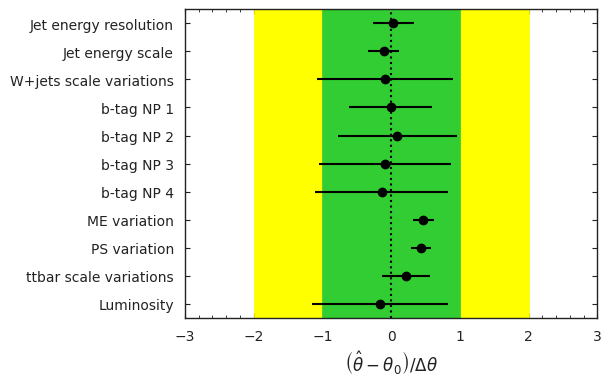

In [17]:
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)

For this pseudodata, what is the resulting ttbar cross-section divided by the Standard Model prediction?

In [18]:
poi_index = model.config.poi_index
print(f"\nfit result for ttbar_norm: {fit_results.bestfit[poi_index]:.3f} +/- {fit_results.uncertainty[poi_index]:.3f}")


fit result for ttbar_norm: 0.953 +/- 0.098


Let's also visualize the model before and after the fit, in both the regions we are using.
The binning here corresponds to the binning used for the fit.

/Users/iason/Dropbox/work/coffea_dev/virtual-array-agc/utils/plotting.py:379: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/iason/Dropbox/work/coffea_dev/virtual-array-agc/utils/plotting.py:379: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[{'figure': <Figure size 1200x600 with 4 Axes>, 'region': '4j1b CR'},
 {'figure': <Figure size 1200x600 with 4 Axes>, 'region': '4j2b SR'}]

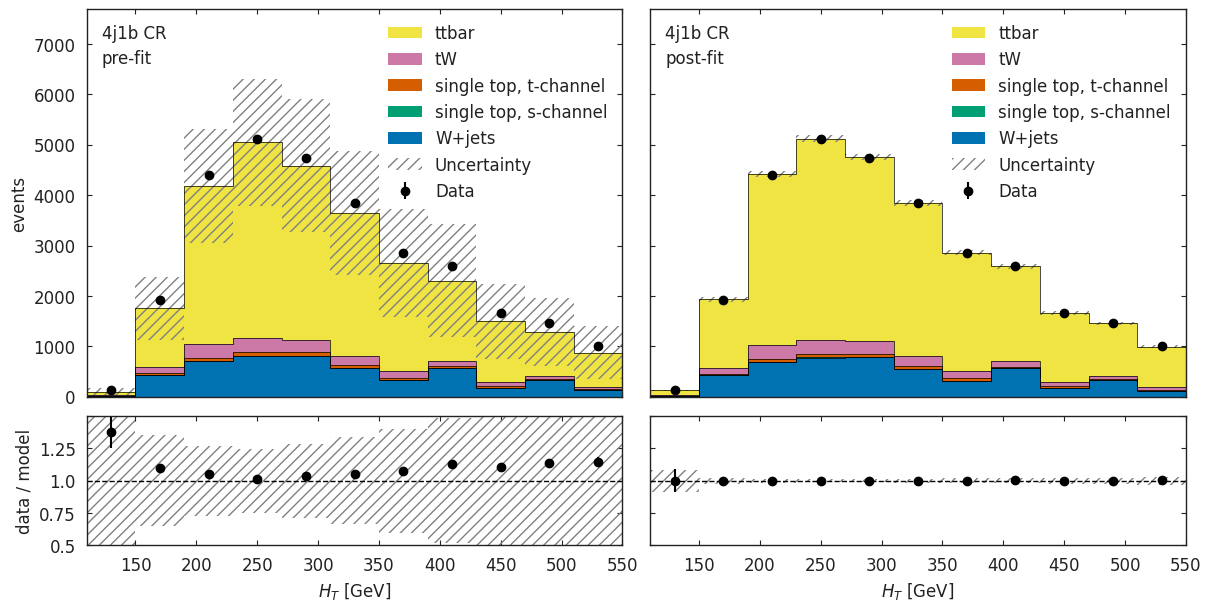

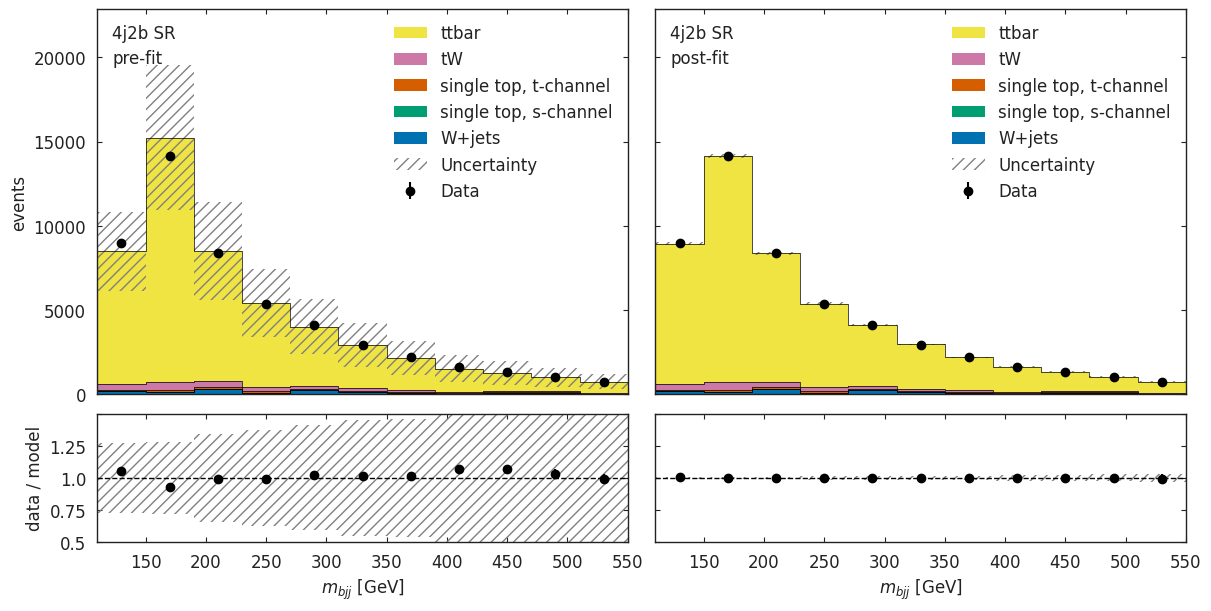

In [19]:
model_prediction = cabinetry.model_utils.prediction(model)
model_prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
figs = cabinetry.visualize.data_mc(model_prediction, data, close_figure=True, config=cabinetry_config)
# below method reimplements this visualization in a grid view
utils.plotting.plot_data_mc(model_prediction, model_prediction_postfit, data, cabinetry_config)

### ML Validation
We can further validate our results by applying the above fit to different ML observables and checking for good agreement.

In [20]:
# load the ml workspace (uses the ml observable instead of previous method)
if USE_INFERENCE:
    config_ml = cabinetry.configuration.load("cabinetry_config_ml.yml")
    cabinetry.templates.collect(config_ml)
    cabinetry.templates.postprocess(config_ml)  # optional post-processing (e.g. smoothing)

    ws_ml = cabinetry.workspace.build(config_ml)
    ws_pruned = pyhf.Workspace(ws_ml).prune(channels=["Feature3", "Feature8", "Feature9",
                                                      "Feature10", "Feature11", "Feature12",
                                                      "Feature13", "Feature14", "Feature15",
                                                      "Feature16", "Feature17", "Feature18",
                                                      "Feature19"])

    cabinetry.workspace.save(ws_pruned, "workspace_ml.json")

In [21]:
if USE_INFERENCE:
    model_ml, data_ml = cabinetry.model_utils.model_and_data(ws_pruned)

We have a channel for each ML observable:

In [22]:
!pyhf inspect workspace_ml.json | head -n 20

                  Summary       
            ------------------  
               channels  7
                samples  5
             parameters  19
              modifiers  19

               channels  nbins
             ----------  -----
               Feature0   25  
               Feature1   25  
               Feature2   25  
               Feature4   25  
               Feature5   25  
               Feature6   25  
               Feature7   25  

                samples
             ----------
                 W+jets


In [23]:
# obtain model prediction before and after fit
if USE_INFERENCE:
    model_prediction_ml = cabinetry.model_utils.prediction(model_ml)
    fit_results_mod = cabinetry.model_utils.match_fit_results(model_ml, fit_results)
    model_prediction_postfit_ml = cabinetry.model_utils.prediction(model_ml, fit_results=fit_results_mod)

/Users/iason/Dropbox/work/coffea_dev/virtual-array-agc/utils/plotting.py:379: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/iason/Dropbox/work/coffea_dev/virtual-array-agc/utils/plotting.py:379: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/iason/Dropbox/work/coffea_dev/virtual-array-agc/utils/plotting.py:379: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/iason/Dropbox/work/coffea_dev/virtual-array-agc/utils/plotting.py:379: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/iason/Dropbox/work/coffea_dev/virtual-array-agc/utils/plotting.py:379: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/iason/Dropbox/work/coffea_dev/virtual-array-agc/utils/plotting.py:379: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/ias

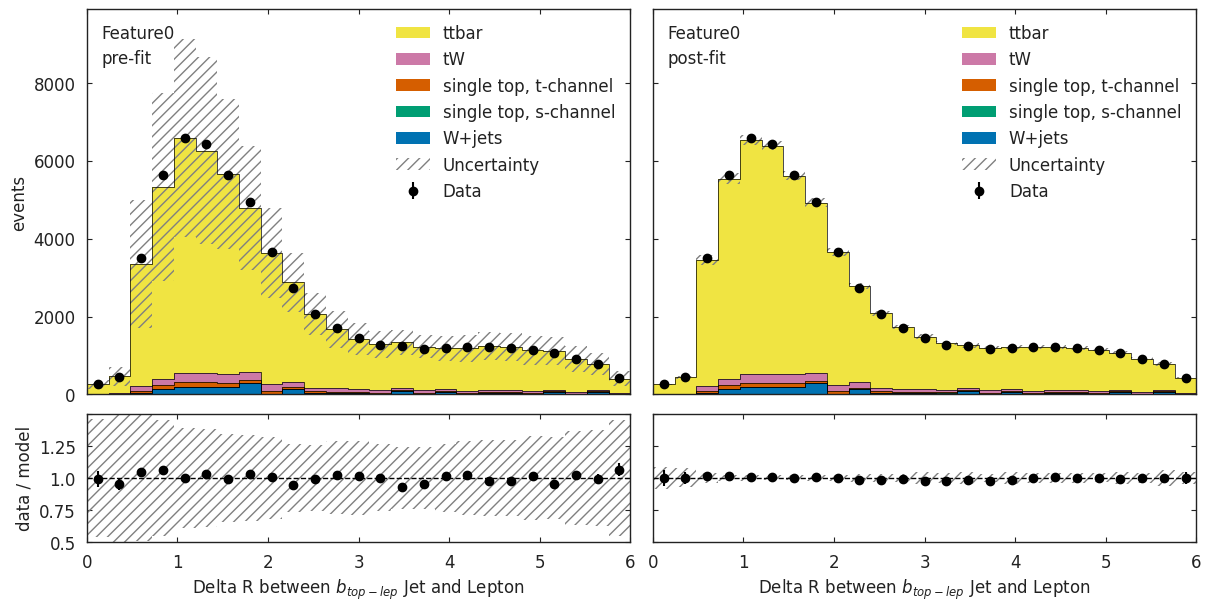

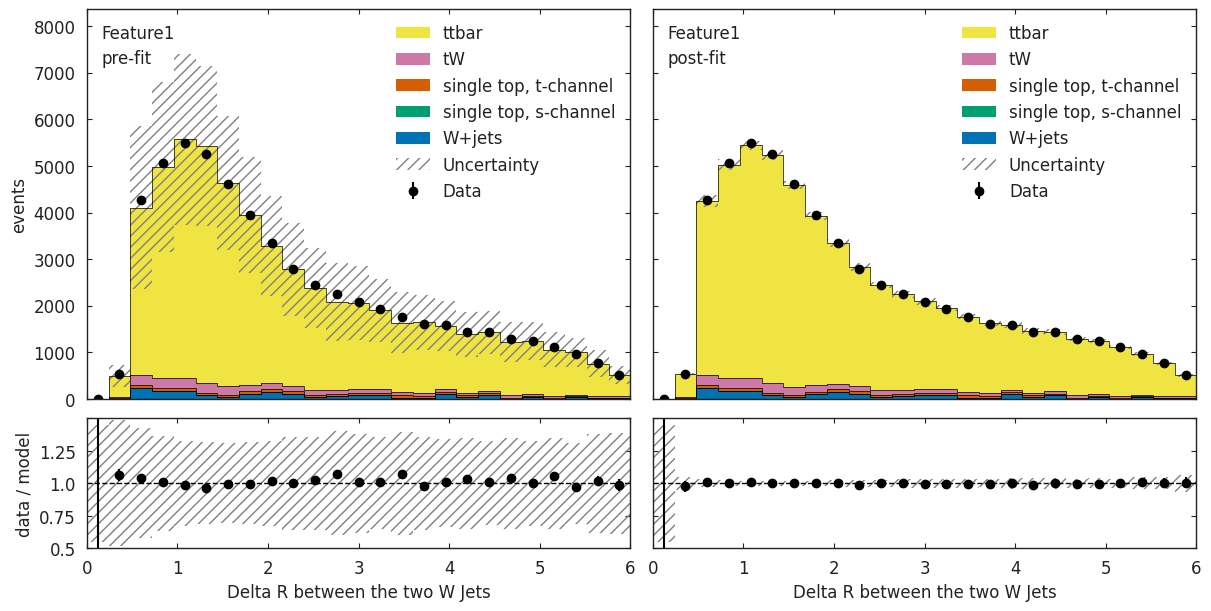

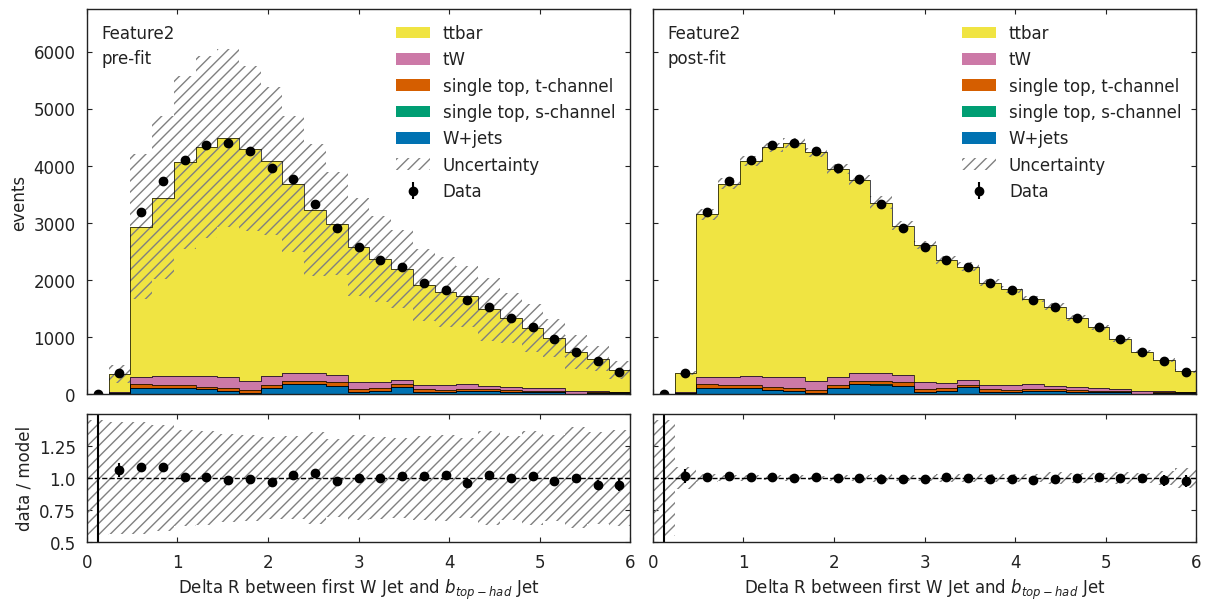

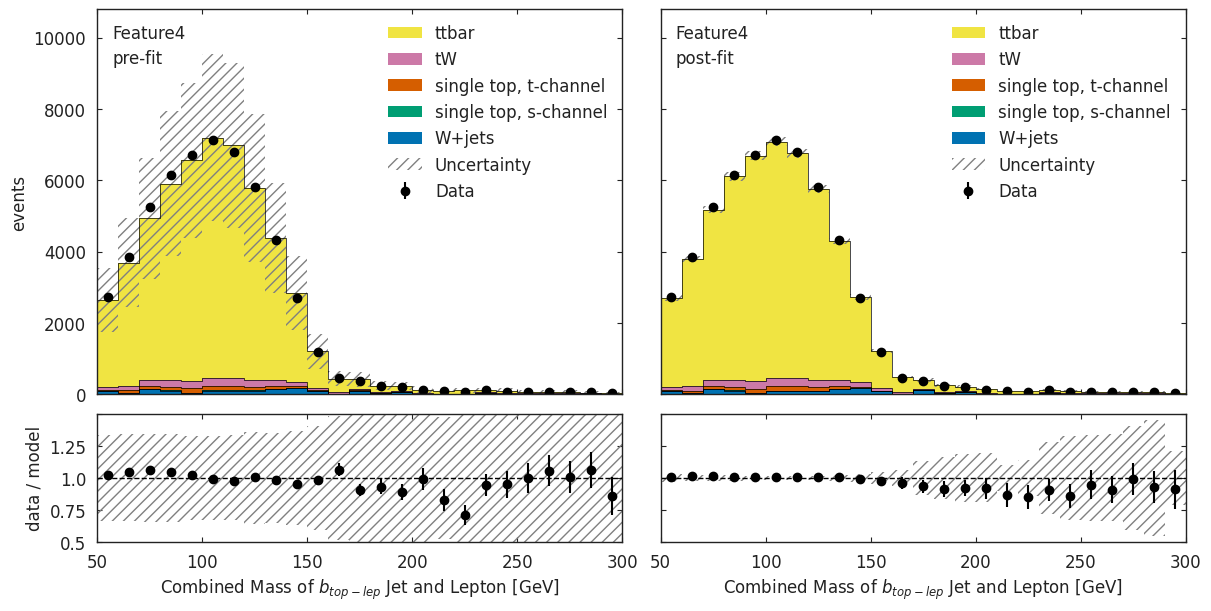

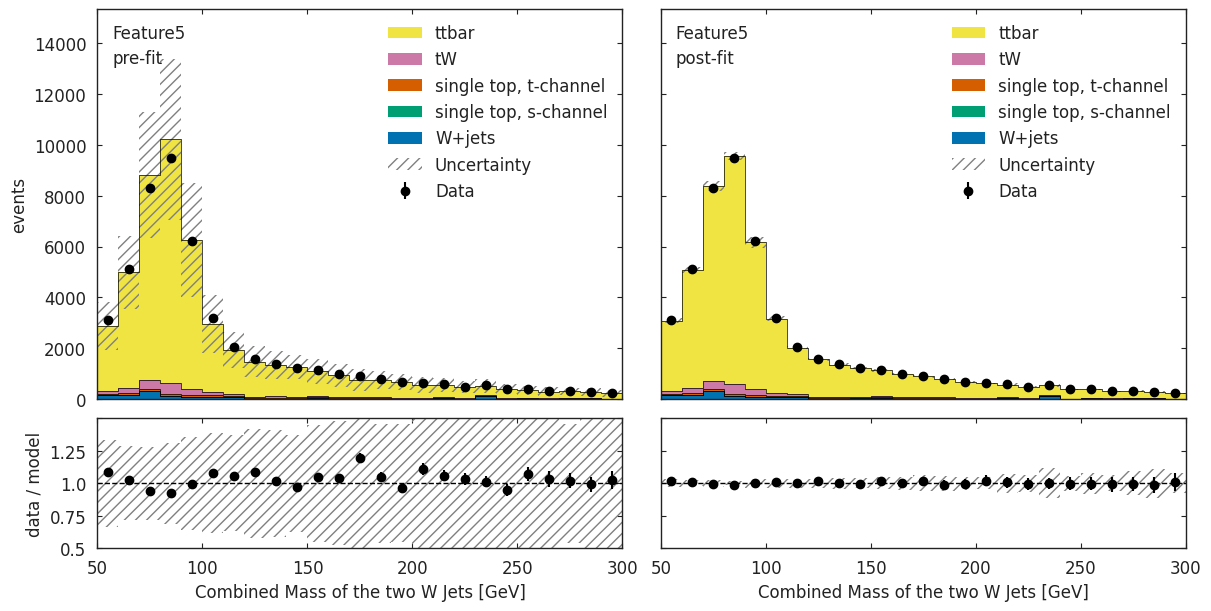

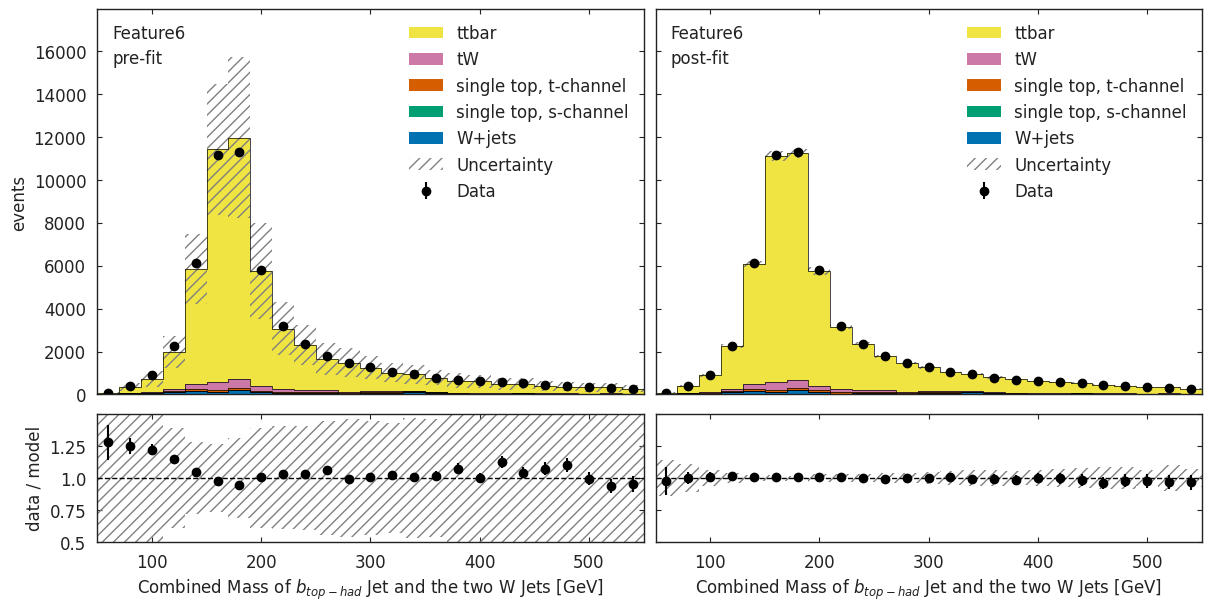

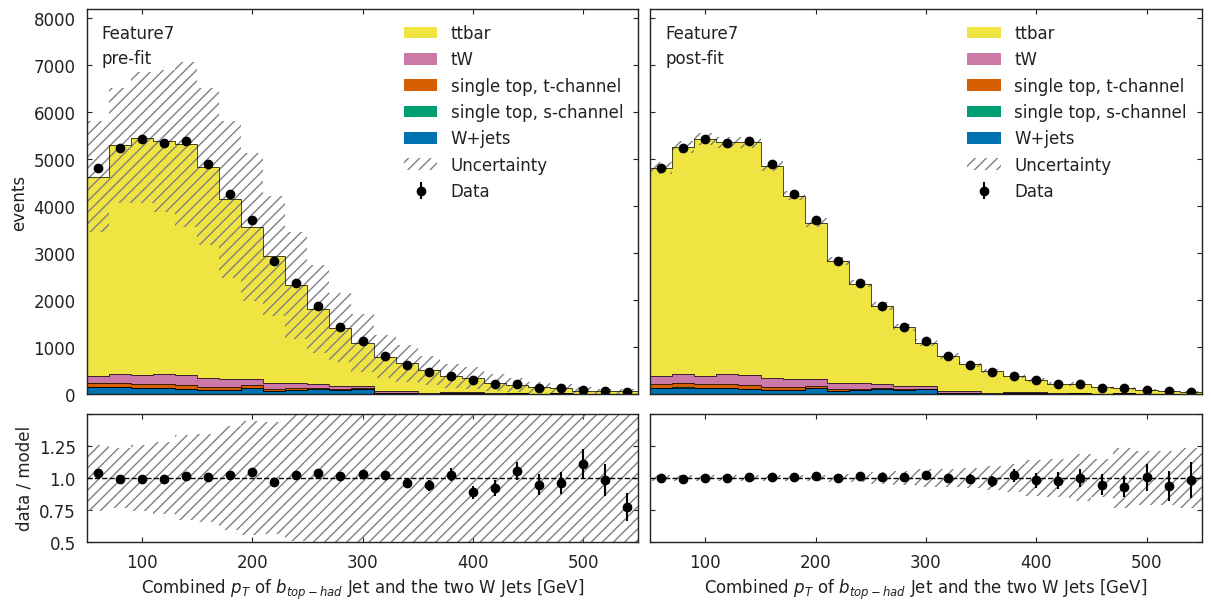

In [24]:
if USE_INFERENCE:
    utils.plotting.plot_data_mc(model_prediction_ml, model_prediction_postfit_ml, data_ml, config_ml)